## Setup
Import required libraries.

In [52]:
import os
from glob import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from napari_dinosim.dinoSim_pipeline import *
from napari_dinosim.utils import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [53]:
#@title Data and Processing Parameters

#@markdown ### Data Settings
ds_path = '/home/tomwelch/Cambridge/neurotransmitter_data/sylee_neurotrans_cubes_18Feb2025' #@param {type:"string"}
dataset = 'acetylcholine' #@param {type:"string"}

#@markdown ### Post-processing Settings
upsample = "bilinear" #@param {type:"string", options:["bilinear", "Nearest Neighbor", "None"], value-map:{bilinear:"bilinear", "Nearest Neighbor": "nearest", None:None}}
crop_shape = (512,512,1) #@param {type:"raw"}

#@markdown ### Model Input Settings
#@markdown Should be multiple of model patch_size
resize_size = 518 #@param {type:"integer"}

In [54]:
with h5py.File(os.path.join(ds_path, dataset, 'acetylcholine_1612-1742_y17627-17757_z10893-11023_1850706912.hdf')) as f:
   print(f.keys(), f['annotations'].keys(), f['annotations/types'][:])

<KeysViewHDF5 ['annotations', 'volumes']> <KeysViewHDF5 ['ids', 'locations', 'presynaptic_site', 'types']> [b'presynaptic_site' b'postsynaptic_site']


## Load Data


In [55]:
import h5py
train_x_fnames = os.listdir(os.path.join(ds_path, dataset))
#train_x_fnames.sort()

with h5py.File(os.path.join(ds_path, dataset, 'acetylcholine_1612-1742_y17627-17757_z10893-11023_1850706912.hdf')) as f:
    pre, post = f['annotations/locations'][:]/8
    x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
    train_dataset = f['volumes/raw'][:][np.newaxis,:,:,z, np.newaxis]
#train_dataset = train_dataset[130,np.newaxis] # add channel dim

print(f'N files:  {len(train_dataset)} \t Shape: {train_dataset.shape}')

N files:  1 	 Shape: (1, 130, 130, 1)


# Load Model

In [56]:
# select model size
model_size = 'small' #@param {type:"string", options:["small", "base", "large", "giant"]}

model_dims = {'small': 384, 'base': 768, 'large': 1024, 'giant': 1536}
assert model_size in model_dims, f'Invalid model size: ({model_size})'
model = torch.hub.load('facebookresearch/dinov2', f'dinov2_vit{model_size[0]}14_reg')
model.to(device)
model.eval()

feat_dim = model_dims[model_size]

few_shot = DinoSim_pipeline(model, model.patch_size, device, get_img_processing_f(resize_size),
                             feat_dim, dino_image_size=resize_size )
print("Model loaded")

Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded


# Prompting

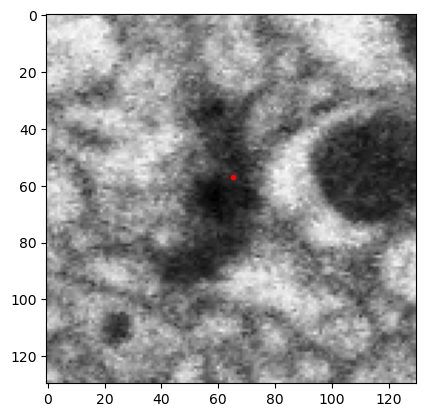

In [57]:
# select reference points
points = [(0, x, y),]
z, x, y = zip(*points)

plt.imshow(train_dataset.squeeze(), 'gray')
plt.scatter(x, y, c='r', marker='.')
plt.show()

# DinoSim

In [58]:
#Post-processing
kernel = gaussian_kernel(size=3, sigma=1)
kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
filter_f = lambda x: torch_convolve(x, kernel)

#few_shot.delete_precomputed_embeddings()
# few_shot.delete_references()
if not few_shot.emb_precomputed:
    few_shot.pre_compute_embeddings(train_dataset, overlap = (0,0), padding=(0,0), crop_shape=crop_shape, verbose=True, batch_size=5)
few_shot.set_reference_vector(list_coords=points)
distances = few_shot.get_ds_distances_sameRef(verbose=False)
predictions = few_shot.distance_post_processing(distances, filter_f, upsampling_mode=upsample)
print("Finished")

Precomputing embeddings


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

Finished


# Plot results

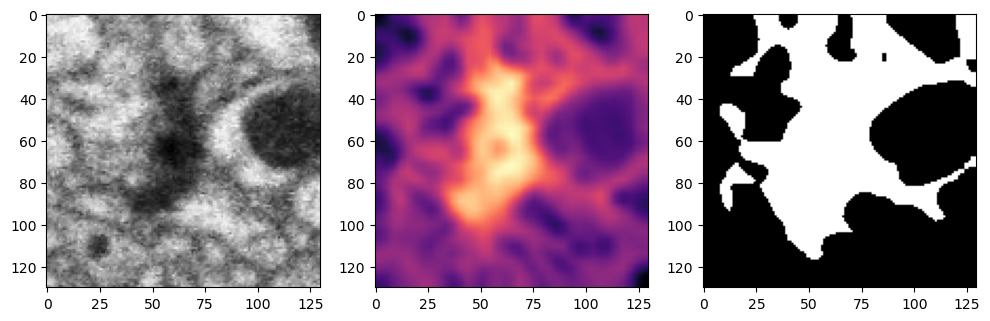

In [59]:
# select threshold
threshold = .5

for i in range(1):
    input_img = train_dataset[i]
    plt.figure(figsize=(12,7))
    plt.subplot(131)
    if input_img.shape[-1] == 1:
        plt.imshow(input_img[...,0], 'gray')
    else:
        plt.imshow(input_img)
    plt.subplot(132)
    plt.imshow(1-predictions[i], 'magma')
    plt.subplot(133)
    plt.imshow(predictions[i] < threshold, 'gray')
    plt.show()